### Importing libs

In [50]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from heuristics.closest_neighbor import closest_neighbor
from typing import List, Dict, Set, Any, Tuple
from itertools import product
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#### Import data set

In [51]:
try:
    data_set = get_data_json("../../data/Denver/42Denver30.json")
    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 2
    Q = vehicle_capacity
    q = demands
    c = distance_matrix
except Exception as e:
    raise e

2024-09-13 10:30:45.960 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualize the distance matrix as a DataFrame

In [52]:
df = pd.DataFrame(c)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0,2206,1938,1904,1405,2161,2498,2811,1136,987,...,4585,6153,6550,7080,6650,6819,7397,9498,9650,9977
1,1757,0,269,652,802,1740,2533,3729,1176,1709,...,6276,7395,7871,8322,7892,8378,8956,11058,11209,11597
2,1489,269,0,383,533,1471,2264,3460,908,1441,...,6008,7126,7603,8053,7624,8109,8687,10789,10940,11329
3,1457,652,383,0,501,1439,2232,3428,874,1407,...,5974,7094,7570,8021,7591,8077,8655,10757,10908,11296
4,956,802,533,501,0,938,1732,2927,375,908,...,5475,6594,7070,7521,7091,7577,8155,10257,10408,10796
5,1685,1740,1471,1439,938,0,943,2641,1104,1197,...,5906,6837,7313,7764,7334,7820,8398,10500,10651,11039
6,1920,2681,2412,2380,1880,1645,0,1698,1532,1450,...,5657,6909,7385,7836,7406,7670,8248,10347,10498,10915
7,2958,3791,3522,3490,2989,3280,1698,0,2639,2189,...,5631,5391,5868,6318,5889,6400,6978,9080,9231,9612
8,692,1176,908,874,375,1025,1450,2646,0,533,...,5100,6312,6788,7239,6809,7295,7873,9975,10126,10474
9,961,1688,1419,1387,887,1178,1513,2179,539,0,...,4709,5845,6322,6772,6342,6828,7406,9508,9659,10048


#### Creating model instance

In [53]:
model = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

#### Define binary

In [54]:
x: Dict[Tuple[int, int], mip.Var] = {
    (i, j): model.add_var(name=f"x_{i}_{j}", var_type=mip.BINARY) for (i, j) in A
}

#### Set the objective function to minimize total distance

In [55]:
model.objective = mip.minimize(
    mip.xsum(int(cost) * x[i, j] for (i, j), cost in A.items())
)

#### Set the m-TSP essential constraints

In [56]:
model += mip.xsum(x[i, i] for i in V) == 0

for j in V - {0}:
    model += mip.xsum(x[i, j] for i in V) == 1  # Inflow
    model += mip.xsum(x[j, i] for i in V) == 1  # Outflow

model += mip.xsum(x[0, j] for j in V - {0}) <= m  # Vehicle limit

model += (
    mip.xsum(x[0, j] for j in V - {0}) - mip.xsum(x[j, 0] for j in V - {0}) == 0
)  # All vehicles used must return to depot

#### Generate an initial solution using closest neighbor heuristics

In [57]:
def generate_initial_solution(
    stations: Set[int],
    demands: List[int],
    distance_matrix: np.matrix,
    vehicle_capacity: int,
    x: Dict[Tuple[int, int], mip.Var],
) -> List[Tuple[mip.Var, int]]:
    depot = 0
    customers = list(stations - {depot})
    demand_dict = dict(enumerate(demands))
    routes = closest_neighbor(
        depot, customers, demand_dict, distance_matrix, vehicle_capacity
    )

    initial_solution: List[Tuple[mip.Var, int]] = []
    for route in routes:
        for i, j in zip(route, route[1:]):
            initial_solution.append((x[i, j], 1))

    return initial_solution

In [58]:
initial_solution = generate_initial_solution(V, q, c, Q, x)

#### Implement separation procedure for subtour elimination

In [59]:
class SeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        demands = self.q
        y = model.translate(self.x)

        qtot = sum(demands)
        demands[0] = qtot

        # First Separation (asymmetric graph G')
        G_prime = nx.DiGraph()
        G_prime.add_nodes_from(vertices)

        u = max(vertices) + 1
        v = max(vertices) + 2

        G_prime.add_nodes_from([u, v])

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for i, j in arcs_prime:
            G_prime.add_edge(i, j, capacity=y[i, j].x)

        for vertice, demand in dict(enumerate(demands)).items():
            if demand > 0:
                G_prime.add_edge(u, vertice, capacity=demand / self.Q)
            else:
                G_prime.add_edge(v, vertice, capacity=-demand / self.Q)

        flow_value, _ = nx.maximum_flow(G_prime, u, v)
        if flow_value < 1:
            _, (S, _) = nx.minimum_cut(G_prime, u, v)
            if len(S) != 0:
                sum_demands = abs(sum(demands[i] for i in S if i in vertices))
                min_vehicles = math.ceil(sum_demands / self.Q)

                tour = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j
                    and y[i, j]
                    and i in S
                    and j in S
                    and i in vertices
                    and j in vertices
                ]
                if sum(value for _, value in tour) >= (len(S) - max(1, min_vehicles)):
                    cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - max(
                        1, min_vehicles
                    )
                    cut_pool.add(cut)

        # Second Separation (asymmetric graph G'')
        G_double_prime = nx.DiGraph()
        G_double_prime.add_nodes_from(vertices)

        G_double_prime.add_nodes_from([u, v])

        # Reverse direction for the second graph G''
        for i, j in arcs_prime:
            G_double_prime.add_edge(i, j, capacity=y[i, j].x)

        for vertice, demand in dict(enumerate(demands)).items():
            if vertice in vertices:  # Check if vertice is in the set of vertices
                if demand < 0:  # Reverse demand directions
                    G_double_prime.add_edge(u, vertice, capacity=-demand / self.Q)
                else:
                    G_double_prime.add_edge(vertice, v, capacity=demand / self.Q)

        # Perform max flow on G''
        flow_value_2, _ = nx.maximum_flow(G_double_prime, u, v)
        if flow_value_2 < 1:
            _, (S_2, _) = nx.minimum_cut(G_double_prime, u, v)
            print("S_2", S_2)
            if len(S_2) != 0:
                sum_demands_2 = abs(sum(demands[i] for i in S_2 if i in vertices))
                min_vehicles_2 = math.ceil(sum_demands_2 / self.Q)

                tour_2 = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j
                    and y[i, j]
                    and i in S_2
                    and j in S_2
                    and i in vertices
                    and j in vertices
                ]
                if sum(value for _, value in tour_2) >= (
                    len(S_2) - max(1, min_vehicles_2)
                ):
                    cut_2 = mip.xsum(1 * var for var, _ in tour_2) <= len(S_2) - max(
                        1, min_vehicles_2
                    )
                    cut_pool.add(cut_2)

        # Add all cuts found during the separation to the model
        for cut in cut_pool.cuts:
            model += cut

        # Restore depot demand
        demands[0] = 0

In [60]:
class SeparationProcedure2(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        depot = 0
        y = model.translate(self.x)

        # Separation S3
        supporting_graph = nx.DiGraph()
        supporting_graph.add_nodes_from(vertices)

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for u, v in arcs_prime:
            supporting_graph.add_edge(u, v, capacity=y[u, v].x)

        for node in vertices - {depot}:
            try:
                flow_value, _ = nx.maximum_flow(supporting_graph, depot, node)
            except nx.NetworkXError as e:
                print(f"Error computing max flow: {e}")
                continue

            if flow_value < 1:
                try:
                    _, (S, _) = nx.minimum_cut(supporting_graph, depot, node)
                except nx.NetworkXError as e:
                    print(f"Error computing min cut: {e}")
                    continue

                tour = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j and y[i, j] and i in S and j in S
                ]

                if sum(value for _, value in tour) >= (len(S) - 1):
                    cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                    cut_pool.add(cut)

                total_demand = abs(sum(self.q[i] for i in S))
                min_vehicles = math.ceil(total_demand / self.Q)

                if min_vehicles < flow_value:
                    if sum(value for _, value in tour) >= (
                        len(S) - max(1, min_vehicles)
                    ):
                        stronger_cut = mip.xsum(1 * var for var, _ in tour) <= len(
                            S
                        ) - max(1, min_vehicles)
                        cut_pool.add(stronger_cut)

        # Separation S4
        def add_dummy_nodes_and_compute_max_flow(graph, vertices, q, Q):
            dummy_source = len(vertices)
            dummy_sink = len(vertices) + 1
            graph.add_node(dummy_source)
            graph.add_node(dummy_sink)

            for i in vertices:
                if q[i] > 0:
                    graph.add_edge(dummy_source, i, capacity=q[i] / Q)
                elif q[i] < 0:
                    graph.add_edge(i, dummy_sink, capacity=-q[i] / Q)

            try:
                flow_value, _ = nx.maximum_flow(graph, dummy_source, dummy_sink)
                return flow_value, nx.minimum_cut(graph, dummy_source, dummy_sink)
            except nx.NetworkXError as e:
                print(f"Error computing max flow or min cut: {e}")
                return None, None

        # First modified supporting graph G'
        supporting_graph_prime = supporting_graph.copy()
        flow_value, min_cut = add_dummy_nodes_and_compute_max_flow(
            supporting_graph_prime, vertices, self.q, self.Q
        )

        if min_cut:
            S, _ = min_cut
            tour = [
                (y[i, j], y[i, j].x)
                for i, j in product(vertices, vertices)
                if i != j and y[i, j] and i in S and j in S
            ]

            if sum(value for _, value in tour) >= (len(S) - 1):
                cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                cut_pool.add(cut)

        # Second modified supporting graph G''
        supporting_graph_double_prime = supporting_graph.copy()
        flow_value, min_cut = add_dummy_nodes_and_compute_max_flow(
            supporting_graph_double_prime, vertices, [-q for q in self.q], self.Q
        )

        if min_cut:
            S, _ = min_cut
            tour = [
                (y[i, j], y[i, j].x)
                for i, j in product(vertices, vertices)
                if i != j and y[i, j] and i in S and j in S
            ]

            if sum(value for _, value in tour) >= (len(S) - 1):
                cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                cut_pool.add(cut)

        for cut in cut_pool.cuts:
            model += cut


In [61]:
model.start = initial_solution
model.cuts_generator = SeparationProcedure2(V, A, q, Q, x)
model.optimize()

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 102 (-1) rows, 2550 (-51) columns and 5150 (-151) elements
Clp1000I sum of infeasibilities 1.71305e-05 - average 1.67946e-07, 2485 fixed columns
Coin0506I Presolve 0 (-102) rows, 0 (-2550) columns and 0 (-5150) elements
Clp0000I Optimal - objective value 39804
Clp0000I Optimal - objective value 39804
Coin0511I After Postsolve, objective 39804, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 39804 Dual inf 49384 (100)
Clp0014I Perturbing problem by 0.001% of 1.000392 - largest nonzero change 2.7080466e-05 ( 0.0013540233%) - largest zero change 2.742797e-05
Clp0000I Optimal - objective value 39804
Clp0000I Optimal - objective value 39804
Clp0000I Optimal - objective value 39804
Coin0511I After Postsolve, objective 39804, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 39804 - 0 iterations time 0.042, Presolve 0.00, Idiot 0.04

Starting MIP optimization


<OptimizationStatus.OPTIMAL: 0>

In [62]:
if model.num_solutions:
    selected_edges = [
        (origin, destination)
        for origin in V
        for destination in V
        if 0.5 <= x[origin, destination].x and x[origin, destination].x <= 1
    ]

    for origin, destination in selected_edges:
        edge_variable = model.var_by_name(f"x_{origin}_{destination}")
        edge_value = x[origin, destination].x
        print(f"{edge_variable} = {edge_value}")

x_1_12 = 1.0
x_2_3 = 1.0
x_3_2 = 1.0
x_4_8 = 1.0
x_5_4 = 1.0
x_6_5 = 1.0
x_7_6 = 1.0
x_8_9 = 1.0
x_9_11 = 1.0
x_10_13 = 1.0
x_11_10 = 1.0
x_12_1 = 1.0
x_13_14 = 1.0
x_14_15 = 1.0
x_15_16 = 1.0
x_16_17 = 1.0
x_17_31 = 1.0
x_18_22 = 1.0
x_19_18 = 1.0
x_20_19 = 1.0
x_21_33 = 1.0
x_22_23 = 1.0
x_23_20 = 1.0
x_24_25 = 1.0
x_25_24 = 1.0
x_26_27 = 1.0
x_27_26 = 1.0
x_28_29 = 1.0
x_29_28 = 1.0
x_30_32 = 1.0
x_31_30 = 1.0
x_32_41 = 1.0
x_33_21 = 1.0
x_34_36 = 1.0
x_35_34 = 1.0
x_36_38 = 1.0
x_37_7 = 1.0
x_38_37 = 1.0
x_39_35 = 1.0
x_40_39 = 1.0
x_41_40 = 1.0
x_42_45 = 1.0
x_43_44 = 1.0
x_44_43 = 1.0
x_45_42 = 1.0
x_46_47 = 1.0
x_47_46 = 1.0
x_48_50 = 1.0
x_49_48 = 1.0
x_50_49 = 1.0


In [63]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -2
Station 2: -4
Station 3: 1
Station 4: 1
Station 5: -3
Station 6: -2
Station 7: 1
Station 8: -2
Station 9: -3
Station 10: 2
Station 11: -8
Station 12: 1
Station 13: 3
Station 14: 2
Station 15: 4
Station 16: 1
Station 17: -1
Station 18: 1
Station 19: -7
Station 20: -4
Station 21: 1
Station 22: -5
Station 23: -3
Station 24: -6
Station 25: -6
Station 26: -6
Station 27: -1
Station 28: 7
Station 29: 1
Station 30: 5
Station 31: 1
Station 32: 1
Station 33: -4
Station 34: -1
Station 35: 3
Station 36: 2
Station 37: -2
Station 38: 3
Station 39: 1
Station 40: 3
Station 41: -2
Station 42: 3
Station 43: -2
Station 44: 1
Station 45: 2
Station 46: -2
Station 47: 1
Station 48: -2
Station 49: -4
Station 50: -5


In [64]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

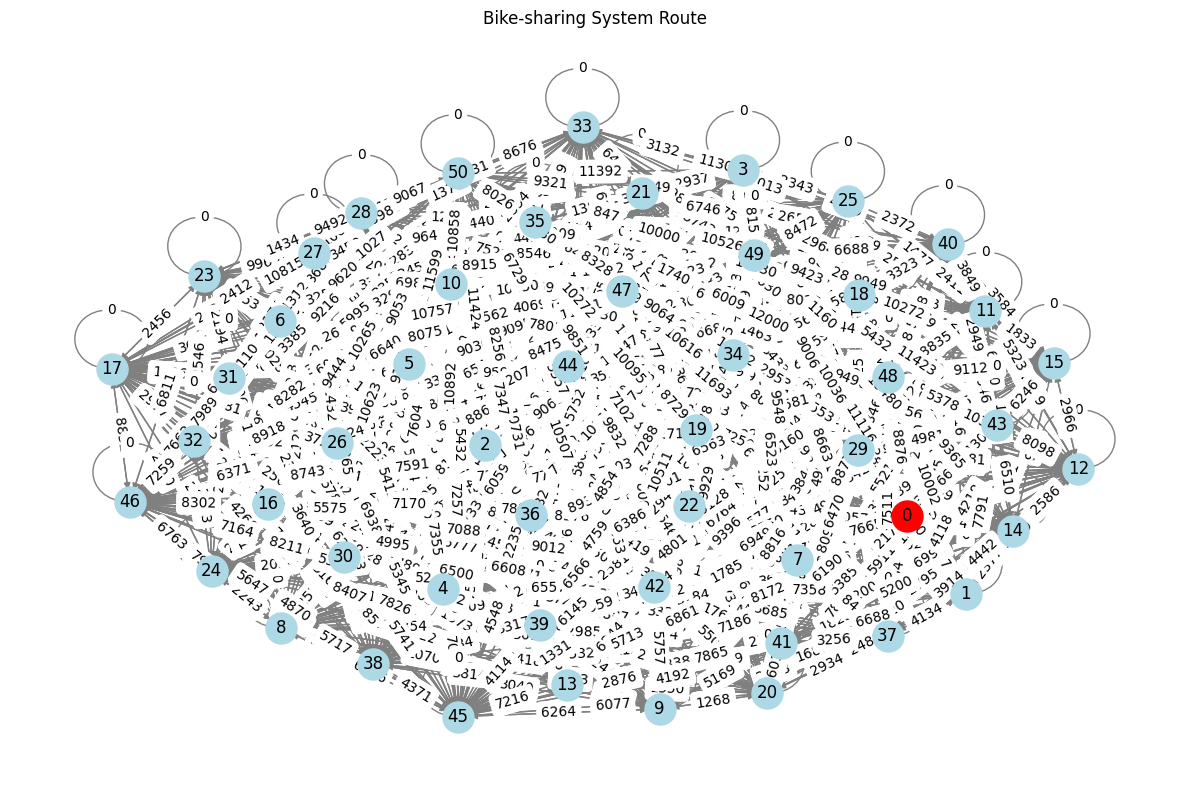

In [65]:
plot_route(V, A)

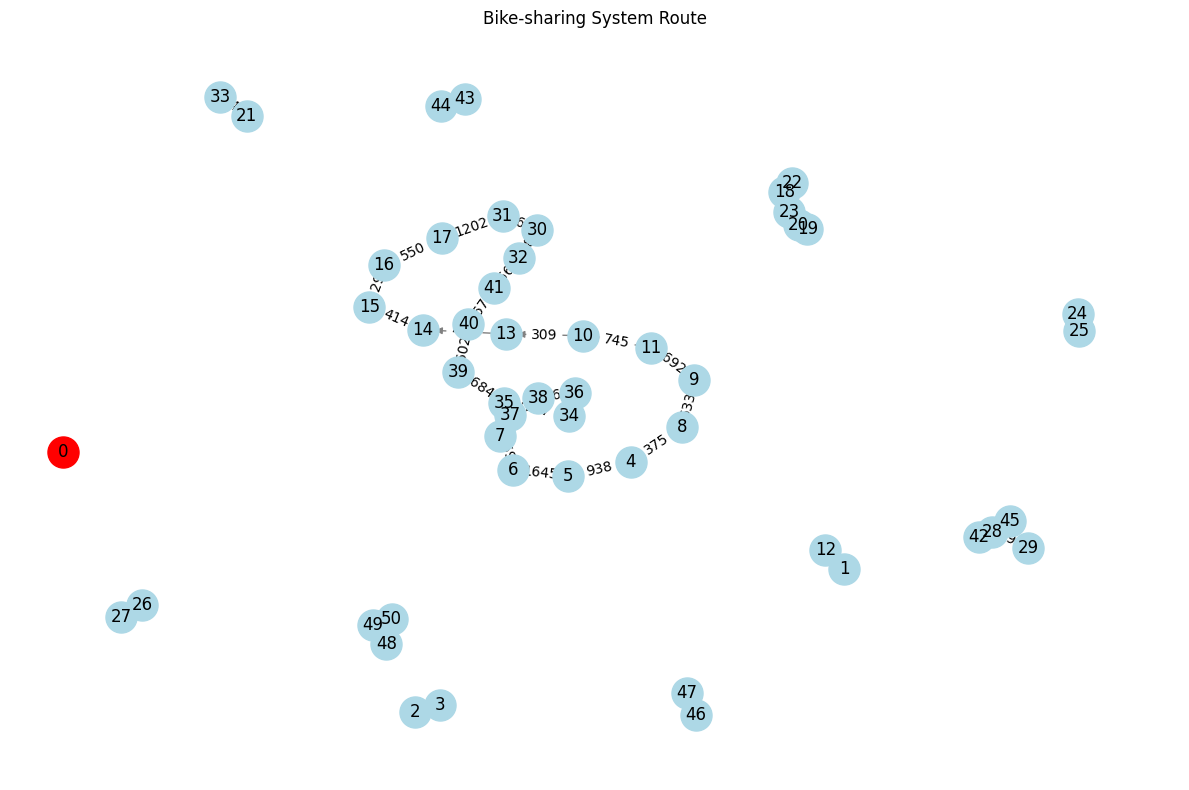

In [66]:
plot_route(V, selected_edges)